In [1]:
def attention_head(n_tokens, dim, dim_head):
    macs = 0
    
    # token -> k, q, v
    macs += n_tokens * 3 * dim * dim_head
    
    # q * k'
    # (n_tokens, dim_head) * (dim_head, n_tokens) -> (n_tokens, n_tokens)
    macs += n_tokens * dim_head * n_tokens
    
    # Softmax e diviso sqrt(dim_head) 
    # ...
    
    # (q * k') * v
    # (n_tokens, n_tokens) * (n_tokens, dim_head) -> (n_tokens, dim_head)
    macs += n_tokens * n_tokens * dim_head
    
    return macs
    
def attention(n_tokens, dim, dim_head, n_heads):
    macs = 0
    
    macs += n_heads * attention_head(n_tokens, dim, dim_head)
    
    # Riporta gli z concatenati a dimensione dim
    macs += n_tokens * (dim_head * n_heads) * dim if not (n_heads == 1 and dim_head == dim) else 0
    
    return macs

def feed_forward(n_tokens, dim, mlp_dim):
    # 2 Linear: dim -> mlp_dim, mlp_dim -> dim
    return n_tokens * dim * mlp_dim * 2

def transformer(n_tokens, dim, dim_head, n_heads, mlp_dim, depth):
    return depth * (attention(n_tokens, dim, dim_head, n_heads) + feed_forward(n_tokens, dim, mlp_dim))

def vit(patch_size, dim, dim_head, n_heads, mlp_dim, depth):
    macs = 0
    
    n_tokens = 300 // patch_size
    
    # linear embedding
    macs += n_tokens * (14 * patch_size) * dim
    
    # +1 perché c'è cls_token
    macs += transformer(n_tokens + 1, dim, dim_head, n_heads, mlp_dim, depth)
    
    # output
    # Da mean o last token a class_scores
    macs += dim * 8
    
    return macs

import torch
from torch import nn, einsum
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)
               
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x)
        qkv = qkv.chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0., use_cls_token=True):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        #self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.use_cls_token = use_cls_token
        if self.use_cls_token:
            self.pos_embedding = nn.Parameter(torch.empty(1, num_patches + 1, dim))
        else:
            self.pos_embedding = nn.Parameter(torch.empty(1, num_patches, dim))
        #nn.init.kaiming_uniform_(self.pos_embedding, a=5 ** .5)
        nn.init.normal_(self.pos_embedding, std=.02)

        #self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.cls_token = nn.Parameter(torch.empty(1, 1, dim))
        nn.init.zeros_(self.cls_token)
        
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        # MACs: patch_size * n_patches * dim, es (30 * 14) * 10 * 300
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape
        
        if self.use_cls_token:
            cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
            x = torch.cat((cls_tokens, x), dim=1)
            x += self.pos_embedding[:, :(n + 1)]
        else :
            x += self.pos_embedding
        
        x = self.dropout(x)
        
        # FeedForward    Attention       project out
        # 300*300*10*2 + 300*(64*3)*10 + ((64)*300*10)
        # Attention -> manca softmax e attention vera e propria, c'è solo linear encoding a qkv
        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]
        
        x = self.to_latent(x)
        x = self.mlp_head(x)
        return x

In [2]:
vit(patch_size=10, dim=64, dim_head=32, n_heads=8, mlp_dim=128, depth=1) / 1e6

3.300864

In [3]:
# Ratio of params
def vit_aff_ratio(patch_size, dim, dim_head, n_heads, mlp_dim, depth): 
    n_tokens = 300 // patch_size + 1
    
    a = (((dim) * dim_head * 3 * n_heads) + ((dim_head * n_heads) * dim) + dim)
    ff = dim * mlp_dim * 2 + mlp_dim + dim
    
    return a / (a + ff)

In [8]:
def vit_config_results(configs, results_, additional_columns):
        
    acccs = []
    acccs_steady = []
    acccs_val0 = []
    acccs_steady_val0 = []
    acccs_val1 = []
    acccs_steady_val1 = []

    acccs_val = 0
    acccs_val_val0 = 0
    acccs_train = 0

    for config, r in zip(configs, results_):

        accs = np.array([0] * len(r['test_sessions']), dtype=float)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_0']['y_preds'], r['val-fold_0']['y_trues'])):
            accs[i] += (y_pred == y_true).sum().float() / len(y_true)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_1']['y_preds'], r['val-fold_1']['y_trues'])):
            accs[i] += (y_pred == y_true).sum().float() / len(y_true)
        accs /= 2

        accs_steady = np.array([0] * len(r['test_sessions']), dtype=float)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_0']['y_preds_steady'], r['val-fold_0']['y_trues_steady'])):
            accs_steady[i] += (y_pred == y_true).sum().float() / len(y_true)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_1']['y_preds_steady'], r['val-fold_1']['y_trues_steady'])):
            accs_steady[i] += (y_pred == y_true).sum().float() / len(y_true)
        accs_steady /= 2

        accs_val0 = np.array([0] * len(r['test_sessions']), dtype=float)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_0']['y_preds'], r['val-fold_0']['y_trues'])):
            accs_val0[i] += (y_pred == y_true).sum().float() / len(y_true)

        accs_steady_val0 = np.array([0] * len(r['test_sessions']), dtype=float)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_0']['y_preds_steady'], r['val-fold_0']['y_trues_steady'])):
            accs_steady_val0[i] += (y_pred == y_true).sum().float() / len(y_true)
            
        accs_val1 = np.array([0] * len(r['test_sessions']), dtype=float)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_1']['y_preds'], r['val-fold_1']['y_trues'])):
            accs_val1[i] += (y_pred == y_true).sum().float() / len(y_true)

        accs_steady_val1 = np.array([0] * len(r['test_sessions']), dtype=float)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_1']['y_preds_steady'], r['val-fold_1']['y_trues_steady'])):
            accs_steady_val1[i] += (y_pred == y_true).sum().float() / len(y_true)

        acccs_train += r['val-fold_0']['losses_accs'][-1]['train_acc']

        acccs_val += .5 * r['val-fold_0']['losses_accs'][-1]['val_acc'] + .5 * r['val-fold_1']['losses_accs'][-1]['val_acc']
        acccs_val_val0 += r['val-fold_0']['losses_accs'][-1]['val_acc']

        acccs.append(accs)
        acccs_steady.append(accs_steady)
        acccs_val0.append(accs_val0)
        acccs_steady_val0.append(accs_steady_val0)
        acccs_val1.append(accs_val1)
        acccs_steady_val1.append(accs_steady_val1)

    acccs = np.array(acccs).mean(axis=0)

    acccs_steady_ = np.array(acccs_steady).mean(axis=1)
    acccs_steady = np.array(acccs_steady).mean(axis=0)

    acccs_val0 = np.array(acccs_val0).mean(axis=0)
    acccs_val1 = np.array(acccs_val1).mean(axis=0)
    acccs_steady_val0 = np.array(acccs_steady_val0).mean(axis=0)
    acccs_steady_val1 = np.array(acccs_steady_val1).mean(axis=0)
    acccs_val /= 10
    acccs_val_val0 /= 10
    acccs_train /= 10

    return {

        "window_size": config["image_size"][1],
        "patch_size": config["patch_size"][1],
        "dim_projection": config["dim"],
        "dim_ff": config["mlp_dim"],
        "dim_head": config["dim_head"],
        "n_heads": config["heads"],
        "depth": config["depth"],
        "dropout": config["dropout"],
        "emb_dropout": config["emb_dropout"],

        **additional_columns,

        "MACs": vit(patch_size=config["patch_size"][1], dim=config["dim"], dim_head=config["dim_head"], n_heads=config["heads"], mlp_dim=config["mlp_dim"], depth=config["depth"]),
        "params":  sum([param.nelement() for param in ViT(image_size=(1, 300), patch_size=config["patch_size"], dim=config["dim"], dim_head=config["dim_head"], heads=config["heads"], mlp_dim=config["mlp_dim"], depth=config["depth"], num_classes=8).parameters()]),
        "params_aff_ratio": vit_aff_ratio(patch_size=config["patch_size"][1], dim=config["dim"], dim_head=config["dim_head"], n_heads=config["heads"], mlp_dim=config["mlp_dim"], depth=config["depth"]),

        "train accuracy steady":  acccs_train,

        "validation accuracy steady": acccs_val_val0,
        #"validation accuracy steady avg2fold": acccs_val,

        "test accuracy": acccs_val0.mean(),
        "test accuracy steady": acccs_steady_val0.mean(),
        "test accuracy fold2": acccs_val1.mean(),
        "test accuracy steady fold2": acccs_steady_val1.mean(), 
        "test accuracy avg2folds": acccs.mean(), 
        "test accuracy steady avg2folds": acccs_steady.mean(),

        "test accuracy steady avg2folds std across sessions": acccs_steady.std(),
        "test accuracy steady avg2folds std across subjects": acccs_steady_.std(),

    }

In [5]:
from pickle import load

import numpy as np
import pandas as pd

def group_configs(configs, group_exclude_columns):
    # https://stackoverflow.com/a/6027615
    import collections.abc

    def flatten(d, parent_key='', sep='_'):
        items = []
        for k, v in d.items():
            new_key = parent_key + sep + k if parent_key else k
            if isinstance(v, collections.abc.MutableMapping):
                items.extend(flatten(v, new_key, sep=sep).items())
            else:
                items.append((new_key, v))
        return dict(items)

    df = pd.DataFrame([flatten(config) for config in configs])
    df['row_id'] = [[a] for a in df.index]

    grouped_configs = df.groupby([c for c in df.columns if c not in group_exclude_columns]).agg({'subjects': 'count', 'row_id': 'sum'})
    
    if (grouped_configs['subjects'] != 10).sum() != 0:
        display(grouped_configs)
        raise ValueError("For every config, it is assumed that you trained on 10 subjects")
    
    return list(grouped_configs["row_id"])
    
def get_results_gridvit(filename, additional_columns=None, group_exclude_columns=None):
    additional_columns = {} if additional_columns is None else additional_columns
    
    group_exclude_columns = set() if group_exclude_columns is None else group_exclude_columns
    group_exclude_columns = group_exclude_columns.union({'subjects', 'row_id'})
    
    configs, results_ = load(open(filename, 'rb'))
    
    groups_indices = group_configs(configs, group_exclude_columns)
    
    df_l = []
    for idx in groups_indices:
        c = [configs[i] for i in idx]
        r = [results_[i] for i in idx]
        
        df_l.append(vit_config_results(c, r, additional_columns))   
    
    return pd.DataFrame(df_l) 

In [6]:
import matplotlib.pyplot as plt

def plot_r(res, ax, legend=True):
    for h in [2, 4, 8]:
        r = res[res["n_heads"] == h]
        ax.grid('on')
        ax.plot(list(map(str, r["depth"])), r["test accuracy steady"], marker='.', markersize=10, label=h)
        ax.set_xlabel("depth")

    if legend:
        ax.legend(title="n_heads", loc="upper right", bbox_to_anchor=(1.25, 1.02))

In [9]:
res = \
    get_results_gridvit("exp5/grid_5sess10subj/finetuneFrom20/results_1623756488.pickle", {"pretraining_epochs": 20, "finetune_epochs": 20}) \
    .append(get_results_gridvit("exp5/grid_5sess10subj/finetuneFrom20For40epochs/results_1623776968.pickle", {"pretraining_epochs": 20, "finetune_epochs": 40}), ignore_index=True) \
    .append(get_results_gridvit("exp5/grid_5sess10subj/finetuneFrom100/results_1623845783.pickle", {"pretraining_epochs": 100, "finetune_epochs": 20}), ignore_index=True)

all_res = res

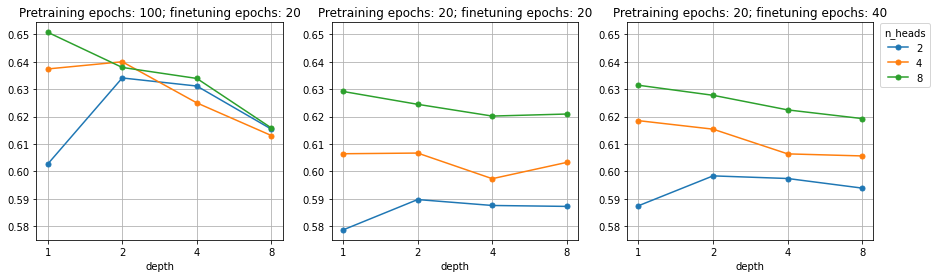

In [10]:
fig, ax = plt.subplots(figsize=(15, 4), ncols=3, sharey=True)
ax[1].yaxis.set_tick_params(labelleft=True)
ax[2].yaxis.set_tick_params(labelleft=True)

plot_r(res[(res["pretraining_epochs"] == 100) & (res["finetune_epochs"] == 20)], ax[0], legend=False)
plot_r(res[(res["pretraining_epochs"] == 20) & (res["finetune_epochs"] == 20)], ax[1], legend=False)
plot_r(res[(res["pretraining_epochs"] == 20) & (res["finetune_epochs"] == 40)], ax[2], legend=True)

ax[0].set_title("Pretraining epochs: 100; finetuning epochs: 20")
ax[1].set_title("Pretraining epochs: 20; finetuning epochs: 20")
ax[2].set_title("Pretraining epochs: 20; finetuning epochs: 40")

None

In [11]:
res = \
    get_results_gridvit("exp5/grid_5sess10subj/finetuneFrom100/results_1623845783.pickle") \
    .append(get_results_gridvit("exp6/grid_5sess10subj_dim64_p10/finetune_100/results_1624706075.pickle"), ignore_index=True) \
    .append(get_results_gridvit("exp6/grid_5sess10subj_dim64_p30/finetune_100/results_1624804897.pickle"), ignore_index=True) \

all_res = all_res.append(res, ignore_index=True)

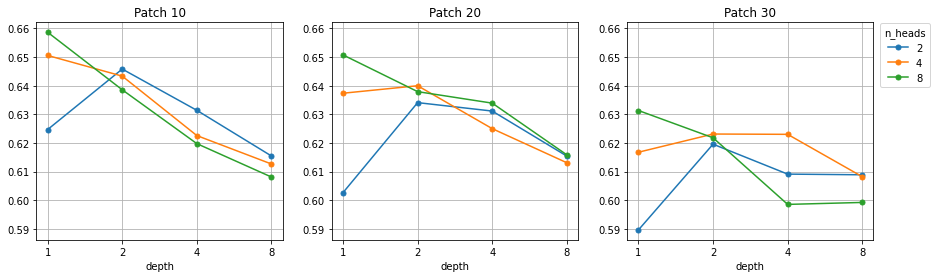

In [12]:
fig, ax = plt.subplots(figsize=(15, 4), ncols=3, sharey=True)
ax[1].yaxis.set_tick_params(labelleft=True)
ax[2].yaxis.set_tick_params(labelleft=True)

plot_r(res[(res["patch_size"] == 10)], ax[0], legend=False)
plot_r(res[(res["patch_size"] == 20)], ax[1], legend=False)
plot_r(res[(res["patch_size"] == 30)], ax[2], legend=True)

ax[0].set_title("Patch 10")
ax[1].set_title("Patch 20")
ax[2].set_title("Patch 30")

None

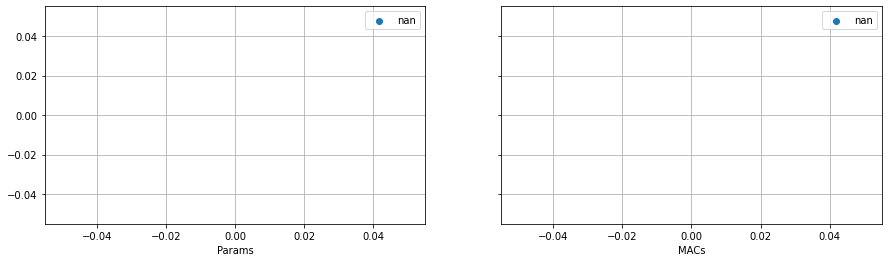

In [16]:
res.loc[res['patch_size'] == 10, "label"] = "10"
res.loc[(res['patch_size'] == 20), "label"] = "20"
res.loc[(res['patch_size'] == 30), "label"] = "30"

fig, ax = plt.subplots(figsize=(15, 4), ncols=2, sharey=True)

for label in res["label"].unique():
    sc = ax[0].scatter(res[res["label"] == label]["params"], res[res["label"] == label]["test accuracy steady"], label=label)
ax[0].legend()
ax[0].set_xlabel("Params")
ax[0].grid("on")

for label in res["label"].unique():
    sc = ax[1].scatter(res[res["label"] == label]["MACs"], res[res["label"] == label]["test accuracy steady"], label=label)
ax[1].legend()
ax[1].set_xlabel("MACs")
ax[1].grid("on")

In [13]:
res = \
    get_results_gridvit("exp8/grid_5sess10subj_patches/finetune_100/results_1626031724.pickle")

all_res = all_res.append(res, ignore_index=True)

In [14]:
res_ = res.append(all_res[(all_res['dim_projection'] == 64) & (all_res['dim_ff'] == 128) & (all_res['dim_head'] == 32) & (all_res['n_heads'] == 8) & (all_res['depth'].isin({1,4})) & (all_res['pretraining_epochs'].isna())])
res_ = res_.sort_values(by=['patch_size'])

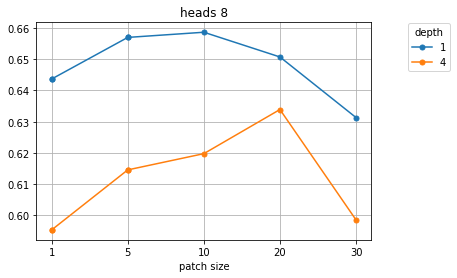

In [15]:
for depth in [1, 4]:
    r = res_[res_['depth'] == depth]
    plt.plot([str(x) for x in r['patch_size']], r['test accuracy steady'], marker='.', markersize=10, label=depth)

plt.grid('on')
plt.xlabel('patch size')
plt.title('heads 8')
plt.legend(title="depth", loc="upper right", bbox_to_anchor=(1.25, 1.02))
None

In [17]:
res = \
    get_results_gridvit("exp6/grid_5sess10subj_dim128/finetune_100/results_1624542865.pickle", {"pretraining_epochs": 100, "finetune_epochs": 20}) \
    .append(get_results_gridvit("exp5/grid_5sess10subj/finetuneFrom100/results_1623845783.pickle", {"pretraining_epochs": 100, "finetune_epochs": 20}), ignore_index=True) \
    .append(get_results_gridvit("exp6/grid_5sess10subj_dim64_biggerff/finetune_100/results_1624804989.pickle", {"pretraining_epochs": 100, "finetune_epochs": 20}), ignore_index=True)

all_res = all_res.append(res, ignore_index=True)

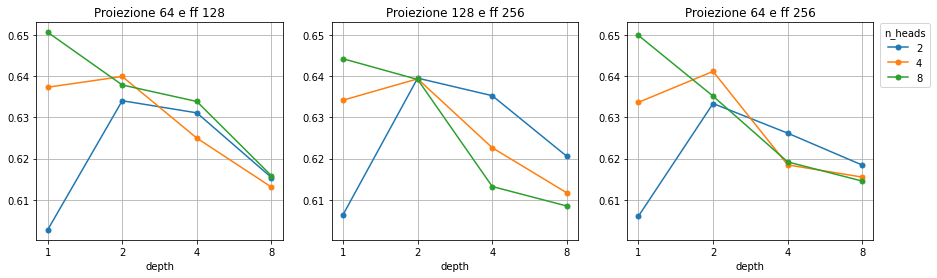

In [18]:
fig, ax = plt.subplots(figsize=(15, 4), ncols=3, sharey=True)
ax[1].yaxis.set_tick_params(labelleft=True)
ax[2].yaxis.set_tick_params(labelleft=True)

plot_r(res[(res["dim_projection"] == 64) & (res["dim_ff"] == 128)], ax[0], legend=False)
plot_r(res[(res["dim_projection"] == 128)], ax[1], legend=False)
plot_r(res[(res["dim_projection"] == 64) & (res["dim_ff"] == 256)], ax[2], legend=True)

ax[0].set_title("Proiezione 64 e ff 128")
ax[1].set_title("Proiezione 128 e ff 256")
ax[2].set_title("Proiezione 64 e ff 256")

None

In [19]:
res = \
    get_results_gridvit("exp6/grid_5sess10subj_dim128/finetune_100/results_1624542865.pickle", {"pretraining_dropout": .2, "pretraining_epochs": 100, "finetune_epochs": 20}) \
    .append(get_results_gridvit("exp6/grid_5sess10subj_dim128_hd/finetune_100/results_1624537254.pickle", {"pretraining_dropout": .4, "pretraining_epochs": 100, "finetune_epochs": 20}), ignore_index=True) \
    .append(get_results_gridvit("exp6/grid_5sess10subj_dim128_hd/finetune_200/results_1624561227.pickle", {"pretraining_dropout": .4, "pretraining_epochs": 200, "finetune_epochs": 20}), ignore_index=True) \
    .append(get_results_gridvit("exp6/grid_5sess10subj_dim128_hd/finetune_300/results_1624568054.pickle", {"pretraining_dropout": .4, "pretraining_epochs": 300, "finetune_epochs": 20}), ignore_index=True)

all_res = all_res.append(res, ignore_index=True)

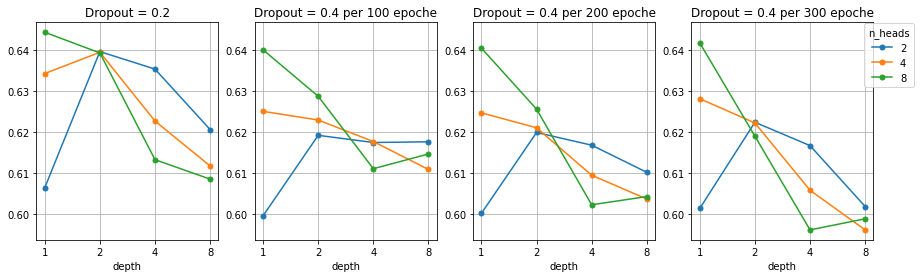

In [20]:
fig, ax = plt.subplots(figsize=(15, 4), ncols=4, sharey=True)
ax[1].yaxis.set_tick_params(labelleft=True)
ax[2].yaxis.set_tick_params(labelleft=True)
ax[3].yaxis.set_tick_params(labelleft=True)

plot_r(res[(res["pretraining_dropout"] == .2) & (res["pretraining_epochs"] == 100)], ax[0], legend=False)
plot_r(res[(res["pretraining_dropout"] == .4) & (res["pretraining_epochs"] == 100)], ax[1], legend=False)
plot_r(res[(res["pretraining_dropout"] == .4) & (res["pretraining_epochs"] == 200)], ax[2], legend=False)
plot_r(res[(res["pretraining_dropout"] == .4) & (res["pretraining_epochs"] == 300)], ax[3], legend=True)

ax[0].set_title("Dropout = 0.2")
ax[1].set_title("Dropout = 0.4 per 100 epoche")
ax[2].set_title("Dropout = 0.4 per 200 epoche")
ax[3].set_title("Dropout = 0.4 per 300 epoche")

None

In [21]:
res = \
    get_results_gridvit("exp6/grid_5sess10subj_dim64_biggerff/finetune_100/results_1624804989.pickle", {"pretraining_dropout": .2, "pretraining_epochs": 100, "finetune_epochs": 20}) \
    .append(get_results_gridvit("exp7/grid_5sess10subj_dim64_biggerff_hd/finetune_100/results_1625404399.pickle", {"pretraining_dropout": .5, "pretraining_epochs": 100, "finetune_epochs": 20}), ignore_index=True) 

all_res = all_res.append(res, ignore_index=True)

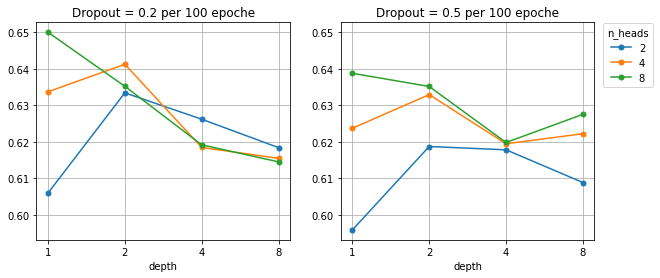

In [22]:
fig, ax = plt.subplots(figsize=(10, 4), ncols=2, sharey=True)
ax[1].yaxis.set_tick_params(labelleft=True)

plot_r(res[(res["pretraining_dropout"] == .2) & (res["pretraining_epochs"] == 100)], ax[0], legend=False)
plot_r(res[(res["pretraining_dropout"] == .5) & (res["pretraining_epochs"] == 100)], ax[1], legend=True)

ax[0].set_title("Dropout = 0.2 per 100 epoche")
ax[1].set_title("Dropout = 0.5 per 100 epoche")

None

In [23]:
res = \
    get_results_gridvit("exp8/grid_5sess10subj_pretraining/finetune_100/results_1626016643.pickle", {"pretraining": 'all_others'}, group_exclude_columns={'pretrained'}) \
    .append(get_results_gridvit("exp8/grid_5sess10subj_nopretraining/finetune_0/results_1626180786.pickle", {"pretraining": 'no'}, group_exclude_columns={'pretrained'}), ignore_index=True) \

all_res = all_res.append(res, ignore_index=True)

In [42]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

r = all_res[(all_res['pretraining_dropout'].isna()) & (all_res['patch_size'] == 20) & (all_res['dim_projection'] == 64) & (all_res['dim_ff'] == 256) & (all_res['dim_head'] == 32) & (all_res['n_heads'] == 8) & (all_res['depth'] == 1)].reset_index(drop=True)
r[['pretraining', 'train accuracy steady', 'validation accuracy steady', 'test accuracy steady']].fillna('first_split')

,pretraining,train accuracy steady,validation accuracy steady,test accuracy steady
0,all,0.902379,0.693077,0.649974
1,all_others,0.831925,0.686031,0.626186
2,no,0.859829,0.647744,0.619294
